# Finding exoplanets with Python + Lightkurve

In [ ]:
pip install lightkurve

In [ ]:
from lightkurve import search_targetpixelfile 
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np

# Let's look at a star we know has a planet
*If we can spot a blob periodically transiting between the star and us, chances are it's an exoplanet*


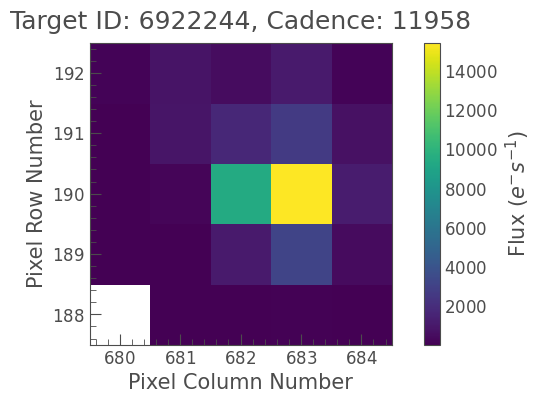

In [ ]:
# Download the pixelfile for a given star
# A quarter means a quarter of a year 
pixelFile = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
# Show a single snapshot 
pixelFile.plot(frame=42)


3.522652265226523 d
353.60132485035285
0.1 d


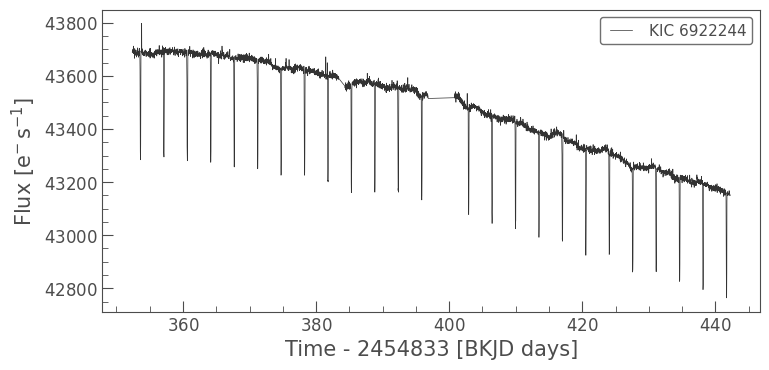

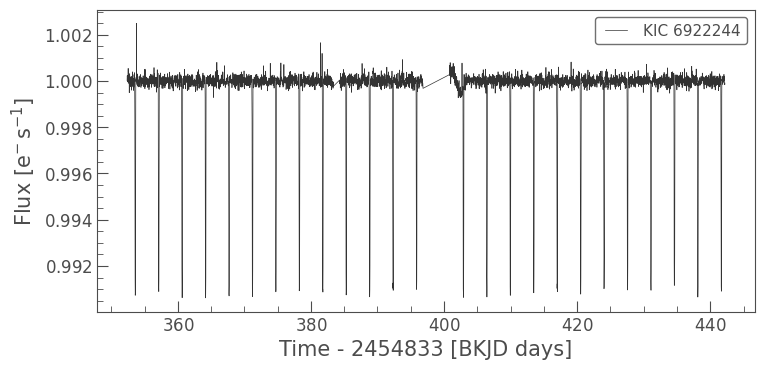

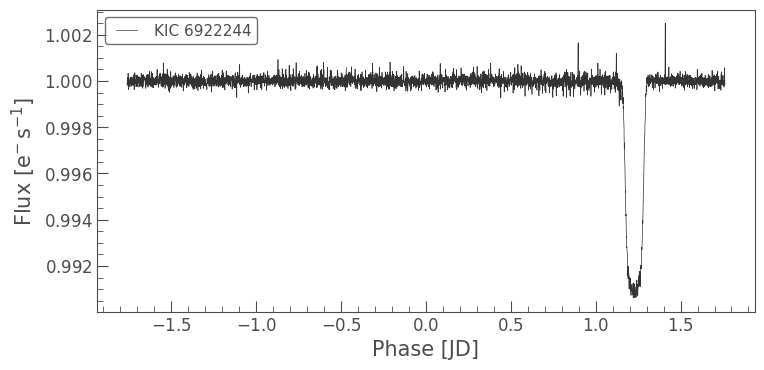

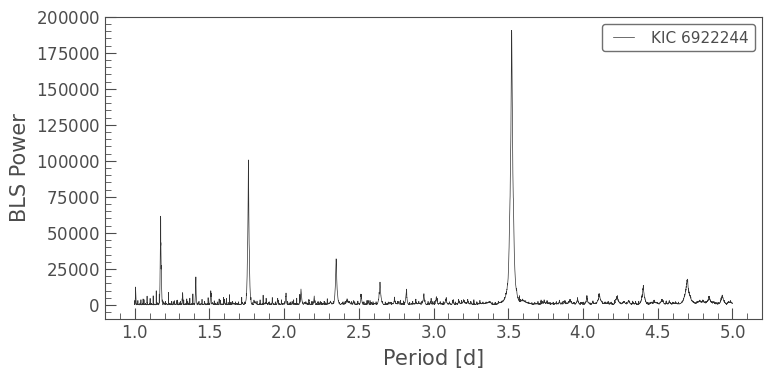

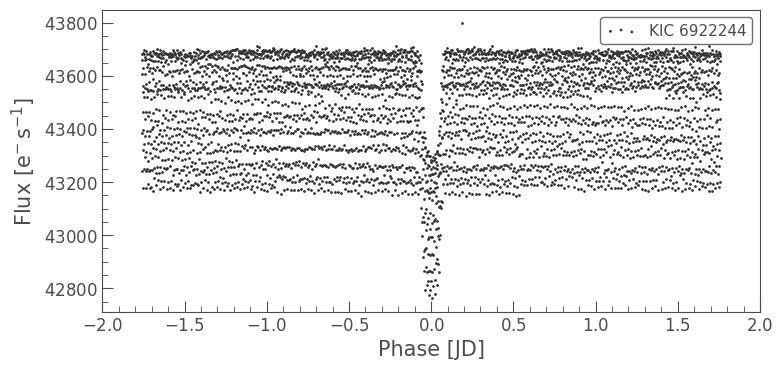

In [ ]:
# We'll combine the individual frames into a lightcurve 
# Aperture masks make the image look better for analysis
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()

# We may find it easier to spot the pattern if we flatten the curve
flat_lc = lc.flatten()
flat_lc.plot()

# Phase-fold the light curve to verify that the period and transit time
# correspond to the transit signal 
# This puts the frequency spikes on top of each other if we get the period right
folded_lc = flat_lc.fold(period=3.5225)
folded_lc.plot()

# How to discover the correct period? 
# Use a periodogram to show all the repetitive patterns in your graph 
# Gives you the most likely candidate

# Periodograms are an estimate of the spectral density of a signal 
# (An estimation of what the Fourier Transform of the data would look like
#  if it were a continuous function https://arxiv.org/pdf/1703.09824.pdf)

period = np.linspace(1, 5, 10000)
# BLS = Box Least Squares
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500) 
bls.plot()

# Period value corresponding to the highest peak in the periodogram 
planet_x_period = bls.period_at_max_power

planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Folding can yield a lot of information about the planet
# The depth can tell you about the size, etc
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-2,2)

print(planet_x_period)
print(planet_x_t0)
print(planet_x_dur)


# Let's try and find a planet!
*Pick a star and try to see if there's something transiting in front of it*

## Selecting a star

In [ ]:
# Use TESS data. That's being updated regularly. Kepler is already well analysed 

# Downloading MAST data
# https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

# Look for nearby stars 
# MAST catalogs -> TESS CTL v8.01 -> Advanced Search
# Has 9.5 million records

# Narrow down the search as you like

# For example:
# T_eff = Temperature between 2000 and 3500
#         These are red dwarfs and tend to have rapidly orbiting planets
#         Which fits the 24 day time sampling rate of TESS

# Distance = Between 12 and 24 parsecs
#            Because we are not able to do the Kessel run in less than 12 

# Take the ID, e.g. 140206488

# Double-check in EXOMAST to see if a planet has already been found

# Put the name in MAST search and find TESS data  
# We can try to access this with search_targetpixelfile
# OR download the data to a local folder 

# Analyze the star

(-3.0, 3.0)

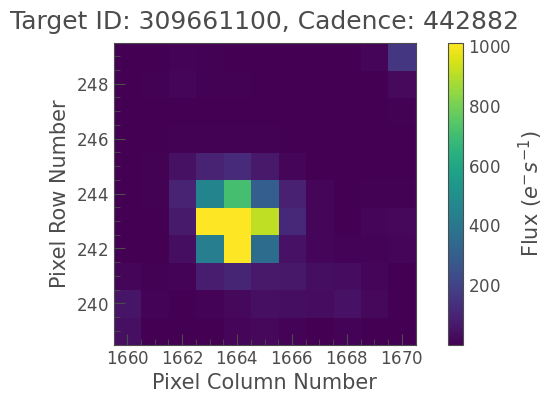

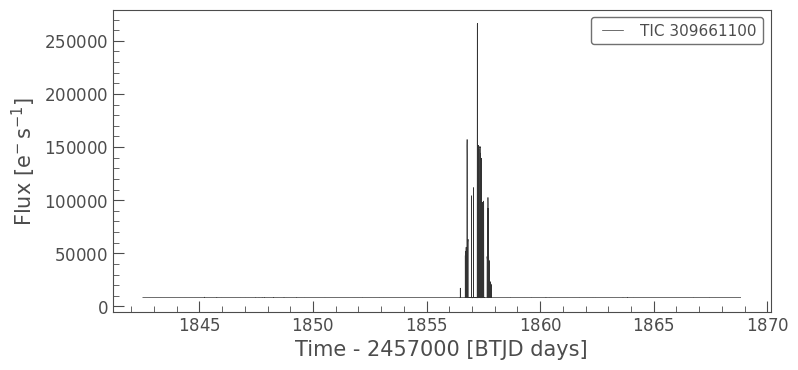

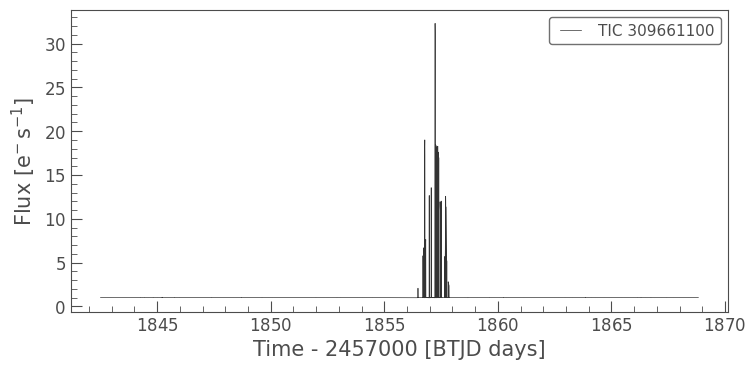

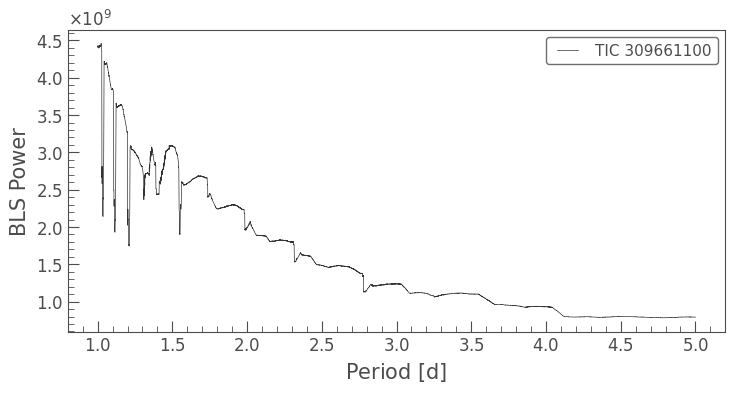

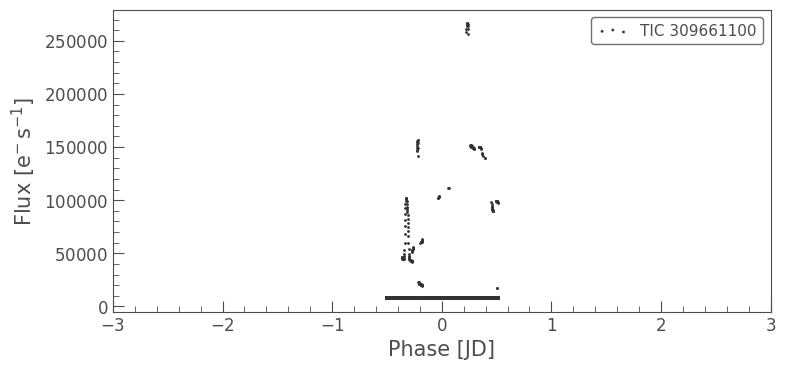

In [ ]:
# Let's download the pixelfile for a given star 
# And save it to a local folder (See download helper below)

# Command to search for file - often is not available, so that's why we download more manually
# pixelFile = search_targetpixelfile('KIC 6922244', author="TESS", cadence="long", quarter=4).download()

tpf = TessTargetPixelFile("/TESS/MAST_2022-01-20T1747/TESS/tess2019357164649-s0020-0000000309661100-0165-s/tess2019357164649-s0020-0000000309661100-0165-s_tp.fits")
# Show a single snapshot 
tpf.plot(frame=42)

# Plot the lightcurve
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

# Flatten it 
flat_lc = lc.flatten()
flat_lc.plot()

# Try and find the period of the most prominent orbiting object
period = np.linspace(1, 5, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

planet_x_period = bls.period_at_max_power
planet_x_t0 = bls.transit_time_at_max_power
planet_x_dur = bls.duration_at_max_power

# Phase-fold the ligthcurve based on the discovered period at max power
ax = lc.fold(period=planet_x_period, epoch_time=planet_x_t0).scatter()
ax.set_xlim(-3,3)

## Download helper 
You can add the URL of the TESS data zip file to be downloaded here and 
get the archive unzipped into the local folder

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

product_group_id = '27240036'
url = 'https://mast.stsci.edu/api/v0.1/Download/bundle.zip?previews=false&obsid=' + product_group_id
destination = '/TESS/'

download_and_unzip(url, destination)
